In [28]:
import pandas as pd

dir = 'out/'
# read the data

benign = pd.read_csv(dir + 'benign.csv')
malicious = pd.read_csv(dir + 'mirai.csv')

benign.head()

,target,id.orig_h_1,id.orig_h_2,id.orig_h_3,id.orig_h_4,id.resp_h_1,id.resp_h_2,id.resp_h_3,id.resp_h_4,missed_bytes,...,history_B,history_S,history_d,history_r,id.orig_p_dyn,id.orig_p_reg,id.orig_p_wk,id.resp_p_dyn,id.resp_p_reg,id.resp_p_wk
0,0,154,197,41,78,192,168,1,198,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0,192,168,1,198,147,231,100,5,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,192,168,1,198,147,231,100,5,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,192,168,1,198,147,231,100,5,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,84,244,188,242,192,168,1,198,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Train test split

In [29]:
print(benign.shape)
print(malicious.shape)

(78618, 33)
(13642435, 33)


In [30]:
# get the numbe of rows in benign and malicious
n_rows_benign = benign.shape[0]
n_rows_malicious = malicious.shape[0]

# select the first 80% of benign as benign_train
benign_train = benign.iloc[:int(n_rows_benign * 0.8), :]

# select the 10% of n_rows_benign * 0.8 from malicious as malicious_train
malicious_train = malicious.iloc[:int(n_rows_benign * 0.8 * 0.1), :]

# print the shape of benign_train and malicious_train
print(benign_train.shape)
print(malicious_train.shape)

(62894, 33)
(6289, 33)


In [31]:
# combine benign_train and malicious_train as X_train
X_train = pd.concat([benign_train, malicious_train], axis=0)

y_train = X_train['target']
X_train = X_train.drop('target', axis=1)

In [32]:
# select the last 20% of benign as benign_test
benign_test = benign.iloc[int(n_rows_benign * 0.8):, :]

# get the number of rows in benign_test
n_rows_benign_test = benign_test.shape[0]

# select the n_rows_benign_test from malicious as malicious_test
malicious_test = malicious.iloc[:n_rows_benign_test, :]

# combine benign_test and malicious_test as X_test
X_test = pd.concat([benign_test, malicious_test], axis=0)

In [33]:
y_test = X_test['target']
X_test = X_test.drop('target', axis=1)

# change 1 to -1 and 0 to 1 in y_test and y_train
y_test = y_test.replace(1, -1)
y_test = y_test.replace(0, 1)

y_train = y_train.replace(1, -1)
y_train = y_train.replace(0, 1)

print(y_test.value_counts())
print()
print(y_train.value_counts())

 1    15724
-1    15724
Name: target, dtype: int64

 1    62894
-1     6289
Name: target, dtype: int64


Isolation forest

In [34]:
# improt isolation forest
from sklearn.ensemble import IsolationForest

# create an isolation forest model
iso = IsolationForest(contamination=0.1)

# fit the model
iso.fit(X_train)

# predict the target for X_test
y_pred = iso.predict(X_test)

C:\Users\Stone\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


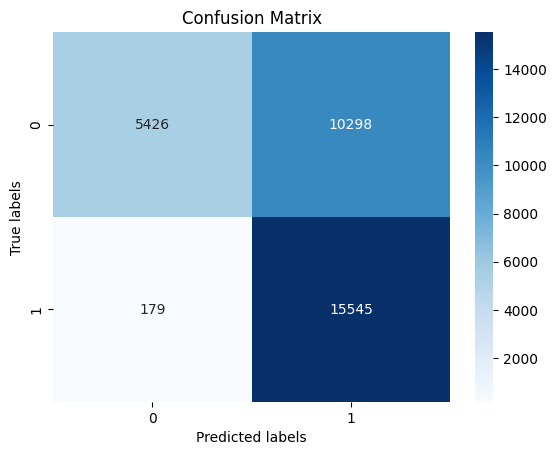

              precision    recall  f1-score   support

          -1       0.97      0.35      0.51     15724
           1       0.60      0.99      0.75     15724

    accuracy                           0.67     31448
   macro avg       0.78      0.67      0.63     31448
weighted avg       0.78      0.67      0.63     31448



In [41]:
# import confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

class_labels = [0, 1] 

# heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

Try to improve recall regardless of precision

In [43]:
import warnings

# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


# import grid search
from sklearn.model_selection import GridSearchCV

# create a dictionary of parameters
params = {'contamination': [0.15, 0.2],
            'n_estimators': [100, 200, 300]}

grid = GridSearchCV(IsolationForest(), params, cv=5, scoring='recall')

# fit the model
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)

{'contamination': 0.15, 'n_estimators': 100}


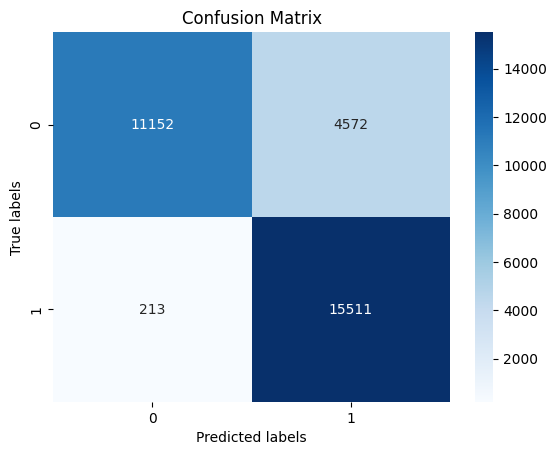

              precision    recall  f1-score   support

          -1       0.98      0.71      0.82     15724
           1       0.77      0.99      0.87     15724

    accuracy                           0.85     31448
   macro avg       0.88      0.85      0.84     31448
weighted avg       0.88      0.85      0.84     31448



In [44]:
# use the best parameters to create a model
iso = IsolationForest(contamination=0.15, n_estimators=100)

# fit the model
iso.fit(X_train)

# predict the target for X_test
y_pred = iso.predict(X_test)

# print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))



One Class SVM

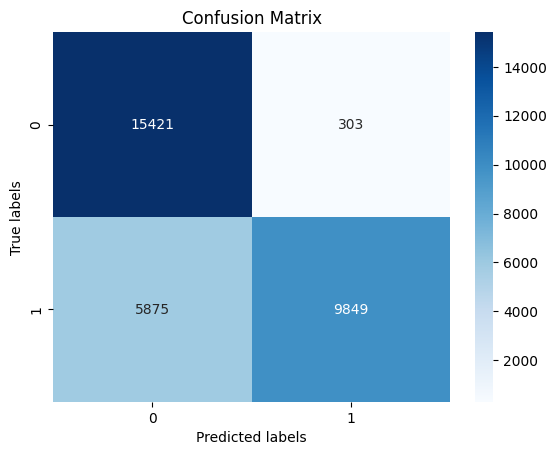

              precision    recall  f1-score   support

          -1       0.72      0.98      0.83     15724
           1       0.97      0.63      0.76     15724

    accuracy                           0.80     31448
   macro avg       0.85      0.80      0.80     31448
weighted avg       0.85      0.80      0.80     31448



In [45]:
# import one class svm
from sklearn.svm import OneClassSVM

# create a one class svm model
svm = OneClassSVM()

# fit the model
svm.fit(X_train)

# predict the target for X_test
y_pred = svm.predict(X_test)

# print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

In [47]:
# create a dictionary of parameters
params = {'nu': [0.1, 0.15, 0.2],
          'gamma': [0.001, 0.01, 0.1],
          'kernel': ['rbf', 'linear']}

grid = GridSearchCV(OneClassSVM(), params, cv=5, scoring='recall')

# fit the model
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)

{'gamma': 0.001, 'kernel': 'linear', 'nu': 0.1}


SVM took 361m40s to complete the grid search

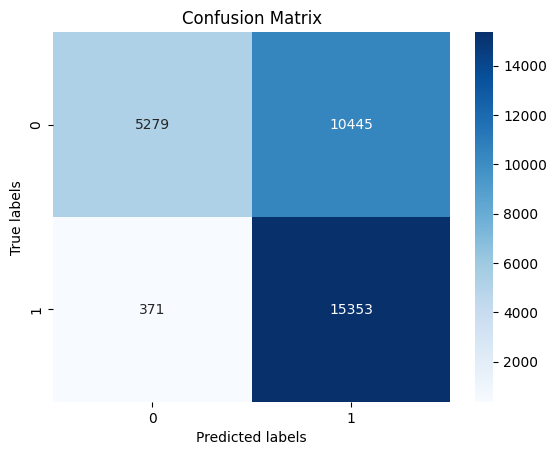

              precision    recall  f1-score   support

          -1       0.93      0.34      0.49     15724
           1       0.60      0.98      0.74     15724

    accuracy                           0.66     31448
   macro avg       0.76      0.66      0.62     31448
weighted avg       0.76      0.66      0.62     31448



In [48]:
# use the best parameters to create a model
svm = OneClassSVM(gamma=0.001, kernel='linear', nu=0.1)

# fit the model
svm.fit(X_train)

# predict the target for X_test
y_pred = svm.predict(X_test)

# print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

Test another dataset

In [53]:
# read okiru.csv
okiru = pd.read_csv(dir + 'okiru.csv')

# print the shape of okiru
print(okiru.shape)

(11378759, 33)


In [54]:
# select the n_rows_benign_test from okiru as okiru_test
okiru_test = okiru.iloc[:n_rows_benign_test, :]

# combine benign_test and okiru_test as X_test_1
X_test_1 = pd.concat([benign_test, okiru_test], axis=0)

y_test_1 = X_test_1['target']
X_test_1 = X_test_1.drop('target', axis=1)

# change 2 to -1 and 0 to 1 in y_test_1
y_test_1 = y_test_1.replace(2, -1)
y_test_1 = y_test_1.replace(0, 1)

In [55]:
# print value counts of y_test_1
print(y_test_1.value_counts())

 1    15724
-1    15724
Name: target, dtype: int64


In [56]:
# iso
y_pred_1 = iso.predict(X_test_1)

# print the classification report
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

          -1       0.98      0.76      0.85     15724
           1       0.80      0.99      0.88     15724

    accuracy                           0.87     31448
   macro avg       0.89      0.87      0.87     31448
weighted avg       0.89      0.87      0.87     31448



In [57]:
# svm  
y_pred_1 = svm.predict(X_test_1)

# print the classification report
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

          -1       0.95      0.46      0.62     15724
           1       0.64      0.98      0.78     15724

    accuracy                           0.72     31448
   macro avg       0.80      0.72      0.70     31448
weighted avg       0.80      0.72      0.70     31448



In [58]:
# rebuild the model with default svm
svm = OneClassSVM()

# fit the model
svm.fit(X_train)

# predict the target for X_test_1
y_pred_1 = svm.predict(X_test_1)

# print the classification report
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

          -1       0.72      0.94      0.81     15724
           1       0.91      0.63      0.74     15724

    accuracy                           0.78     31448
   macro avg       0.82      0.78      0.78     31448
weighted avg       0.82      0.78      0.78     31448

